In [27]:
import torch
from diffusers import StableDiffusionXLPipeline
from PIL import Image

from ip_adapter import IPAdapterXL

In [28]:
base_model_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"
image_encoder_path = "sdxl_models/image_encoder"
ip_ckpt = "sdxl_models/ip-adapter_sdxl.bin"
device = "cuda"

In [21]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [30]:
# load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    add_watermarker=False,
)

Loading pipeline components...:  33%|███▎      | 2/6 [00:00<00:01,  3.36it/s]/Data/miXup/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.87it/s]


In [41]:
# load ip-adapter
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device)

OSError: sdxl_models/image_encoder is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

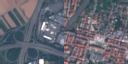

In [25]:
# read image prompt
image = Image.open("assets/images/Highway_2.jpg")
image.resize((512, 512))

image2 = Image.open("assets/images/Residential_13.jpg")
image2.resize((512, 512))

doubleimage = [image, image2]

grid = image_grid([image, image2], 1, 2)
grid

In [35]:
# generate image variations with only image prompt
num_samples = 1
images = ip_model.generate(pil_image=doubleimage, num_samples=num_samples, num_inference_steps=20, seed=420, scale=0.5)

grid = image_grid(images, 1, 2)
grid

NameError: name 'ip_model' is not defined

In [37]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=num_samples, num_inference_steps=30, seed=420,
        prompt="best quality, high quality, wearing sunglasses on the beach", scale=0.6)
grid = image_grid(images, 1, num_samples)
grid

NameError: name 'ip_model' is not defined

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image
import ip_adapter

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    image_encoder=image_encoder
)

# pipeline.scheduler = DDIMScheduler.from_config(pipeline.load_ip_adapterscheduler.config)

pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="models",
  weight_name=["ip-adapter-plus_sd15.safetensors", "ip-adapter-plus_sd15.safetensors"]
)




/Data/miXup/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:  14%|█▍        | 1/7 [00:02<00:17,  2.99s/it]/Data/miXup/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:48<00:00,  6.86s/it]


100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


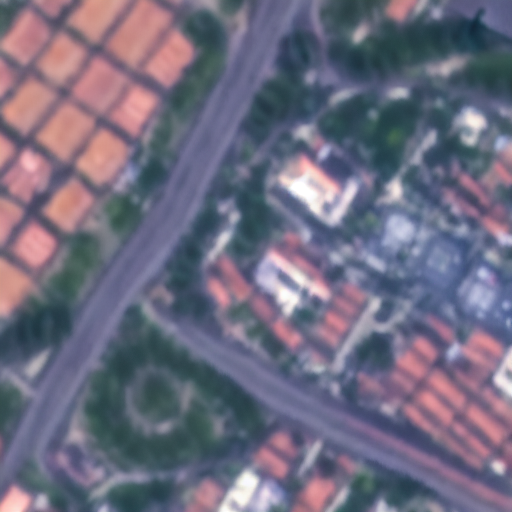

In [26]:
pipeline.set_ip_adapter_scale([0.5,
                               0.5]) 
pipeline.enable_model_cpu_offload()


image = Image.open("assets/images/Highway_2.jpg")
# image.resize((512, 512))

image2 = Image.open("assets/images/Residential_13.jpg")
# image2.resize((512, 512))



generator = torch.Generator(device="cuda").manual_seed(0)

image = pipeline(
    prompt="A satellite photo",
    ip_adapter_image=[image, image2],
    negative_prompt="monochrome, lowres, worst quality, low quality",
    num_inference_steps=100, num_images_per_prompt=1,
    generator=generator,
).images[0]
image

In [ ]:

import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

def select_random_images(dataset_path, num_images=2):
    selected_images = []
    n = 0
    for root, dirs, files in os.walk(dataset_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            
            image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            
            if len(image_files) >= num_images:
                selected_files = random.sample(image_files, num_images)

                for file in selected_files:
                    selected_images.append(os.path.join(dir_path, file))

                image = Image.open(selected_images[0])
                image2 = Image.open(selected_images[1])
                generator = torch.Generator(device="cuda").manual_seed(0)

                image = pipeline(
                    prompt="A satellite photo",
                    ip_adapter_image=[image, image2],
                    negative_prompt="monochrome, lowres, worst quality, low quality",
                    num_inference_steps=100, num_images_per_prompt=1,
                    generator=generator,
                ).images[0]

                image.save('double-ipa-outputs/image' + str(n) + '.png' )
                n+=1

    return selected_images


dataset_path = './DataDream/data/eurosat/real_train_fewshot/seed0'


selected_images = select_random_images(dataset_path)
